### Catch Probability - an ingredient for new defensive baseball statistics

There are many statistics for batting and pitching, but there aren't many defensive statistics.  The primary reason is that batters and pitchers have a clear outcome for every baseball 'event' - was a strike or ball thrown, was a hit made and what base movement occured.  But in defensive statistics, one of the only metrics is the 'error' (which is a very low probability event - about 1.5% of all balls hit into play in 2017 resulted in an error).  Yet there seems a lot of variability in outcomes of what fly balls and line-drives are caught, but no good metric to measure this.

There has been great breakthroughs in thinking about this in the past 2 years due to improvements in Stacast data from the MLB.  The basic idea is that if you know the probability that a ball in flight is caught (catch probability), and you know where a player decides to position themself before a bat is hit into play, you could see if that player 'outperformed' other players over tens of thousands of hits in the same position catching the ball.   This is especially interesting for outfielders, who  have the most amount of 'hang time' to position themselves after a ball is hit.

My professor turned me on to the great power of Statcast data with this work, by suggesting I look at pybasell library.  Up to this point the class looked at traditional data sources (Lahman, Retrosheet and data recorded in FanGraphs).  pybaseball pulled some data from a site called  basebasesavant.mlb.com which contained a *very* interesting set of Statcast Data.

From that starting point began the journey to  understand 'catch probability' - which at its core can be predicted by three things:
1. Launch speed - the speed in mph that a ball leaves a batters bat (range is 0-125mph)
2. Launch angle - the angle the ball leaves the batters bat (+/- 70 degrees)
3. A data set of whether balls were caught with the same launch angle and launch speed.

This notebook outlines the activity to:

1. Acquire the raw data (using all balls hit into play in the 2017 season)
2. Inspect and validate the raw data
3. Augment dataset with new columns
4. Analyze augmented data set
5. Prove that the new statcast metrics of launch speed  and and launch speed were statistically valid
6. Develop a model that forward predicts 'catch probability'
7. Demonstrate catch probability in an application (this notebook).

Starting points:
- __[pybaseball](https://github.com/jldbc/pybaseball/blob/master/pybaseball/statcast.py)__
- statcast data available - scraped from [baseballsavant.mlb.com][https://baseballsavant.mlb.com/statcast_search]
- Catch probability - Statcast overview https://www.mlb.com/news/statcast-introduces-catch-probability-for-2017/c-217802340

Note: before this class I had been to a few baseball games, was a novice about baseball rules, knew NOTHING about baseball metrics/statistics.  

In [4]:
%matplotlib inline
import math

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from numpy import arange

import statsmodels.api as sm
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

## Step 1. Acquire the raw data (using all balls hit into play in the 2017 season)
pybaseball is a terrific python package that accesses traditional datasets and new ones (like this Statcast data). It is easily used and there are great examples and documentation on their Github site.   The Statcast data I am interested is batter hitting data, and the MLB doesn't provide any direct method to access this (in fact there are very opaque about providing the raw 'statcast' metrics in general).   

pybaseball has some code (my modified version is below) to screen scrape data from the baseball.savant site (which is a treasure trove of data itself, but mostly via its 'search' function.   pybaseball introduces an api called batter_statcast() which pulls data based on a date range and a batter id.   After playing around with this, it looked like it would take hours and hours to run an automated query to pull data batter by batter for the 2017 season.  

As a fluke, I played around with the pitcher_statcast() call and modified it to pull data on batters.  With ** one simple line of code ** change, I could get the same module to pull batter data (all batters at once in a date range) AND to eliminate the return of any data except balls put into play.  This eliminated 75% of the raw data return, and improved overall query perfomance by greater than 10 times.  The entire 2017 dataset of balls hit into play can be acquired in under five minutes.

You don't need an account with baseball.savant or mlb or anyone to pull the data, just run the modified code below.
There is no 'hide cell' function, so here goes.

Just a single line of code change to make pybaseball scream (at least for this dataset)

### 1a. Mods to pybaseball to have it scrape  Statcast data 10X faster and for all batters in league

### 1b. Get Raw Data from modified Baseball Savant scraper for the 2017 season
#### this takes 2-3 minutes

In [5]:
#modified code from pybaseball
#modification to screen scrape the 'batter' data at approx 10X the speed of pybaseball
#simply by only including 'event' pitches (balls hit into play, caught for an out etc)
#this model ignores all other pitches (balls, strikes)
#also, this returns data for ALL players, not just a single batter.
#data subsetted to Regular Season and Playoff only - no spring training

import numpy as np
import pandas as pd
import requests
import datetime
import warnings
import io

def validate_datestring(date_text):
    try:
        datetime.datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")

def sanitize_input(start_dt, end_dt):
    # if no dates are supplied, assume they want yesterday's data
    # send a warning in case they wanted to specify
    if start_dt is None and end_dt is None:
        today = datetime.datetime.today()
        start_dt = (today - datetime.timedelta(1)).strftime("%Y-%m-%d")
        end_dt = today.strftime("%Y-%m-%d")
        print("Warning: no date range supplied. Returning yesterday's Statcast data. For a different date range, try get_statcast(start_dt, end_dt).")
    #if only one date is supplied, assume they only want that day's stats
    #query in this case is from date 1 to date 1
    if start_dt is None:
        start_dt = end_dt
    if end_dt is None:
        end_dt = start_dt
    # now that both dates are not None, make sure they are valid date strings
    validate_datestring(start_dt)
    validate_datestring(end_dt)
    return start_dt, end_dt

def single_game_request(game_pk):

    url = "https://baseballsavant.mlb.com/statcast_search/csv?all=true&type=details&game_pk={game_pk}".format(game_pk=game_pk)
    s=requests.get(url, timeout=None).content
    data = pd.read_csv(io.StringIO(s.decode('utf-8')))#, error_bad_lines=False) # skips 'bad lines' breaking scrapes. still testing this.
    return data

# modified the url to return batter data, and only 'player-event' data (cuts data set by 75%)
def small_request(start_dt,end_dt):
    #url = "https://baseballsavant.mlb.com/statcast_search/csv?all=true&hfPT=&hfAB=&hfBBT=&hfPR=&hfZ=&stadium=&hfBBL=&hfNewZones=&hfGT=R%7CPO%7C=&hfSea=&hfSit=&player_type=pitcher&hfOuts=&opponent=&pitcher_throws=&batter_stands=&hfSA=&game_date_gt={}&game_date_lt={}&team=&position=&hfRO=&home_road=&hfFlag=&metric_1=&hfInn=&min_pitches=0&min_results=0&group_by=name&sort_col=pitches&player_event_sort=h_launch_speed&sort_order=desc&min_abs=0&type=details&".format(start_dt, end_dt)
    url = "https://baseballsavant.mlb.com/statcast_search/csv?all=true&hfPT=&hfAB=&hfBBT=&hfPR=&hfZ=&stadium=&hfBBL=&hfNewZones=&hfGT=R%7CPO%7CS%7C=&hfSea=&hfSit=&player_type=batter&hfOuts=&opponent=&pitcher_throws=&batter_stands=&hfSA=&game_date_gt={}&game_date_lt={}&team=&position=&hfRO=&home_road=&hfFlag=&metric_1=&hfInn=&min_pitches=0&min_results=0&group_by=name-event&sort_col=pitches&player_event_sort=h_launch_speed&sort_order=desc&min_abs=0&type=details&".format(start_dt, end_dt)
    s=requests.get(url, timeout=None).content
    data = pd.read_csv(io.StringIO(s.decode('utf-8')))#, error_bad_lines=False) # skips 'bad lines' breaking scrapes. still testing this.
    return data

def large_request(start_dt,end_dt,d1,d2,step,verbose):
    """
    break start and end date into smaller increments, collecting all data in small chunks and appending all results to a common dataframe
    end_dt is the date strings for the final day of the query
    d1 and d2 are datetime objects for first and last day of query, for doing date math
    a third datetime object (d) will be used to increment over time for the several intermediate queries
    """
    error_counter = 0 # count failed requests. If > X, break
    no_success_msg_flag = False # a flag for passing over the success message of requests are failing
    print("This is a large query, it may take a moment to complete")
    dataframe_list = []
    #step = 3 # number of days per mini-query (test this later to see how large I can make this without losing data)
    d = d1 + datetime.timedelta(days=step)
    while d <= d2: #while intermediate query end_dt <= global query end_dt, keep looping
        # dates before 3/15 and after 11/15 will always be offseason
        # if these dates are detected, check if the next season is within the user's query
        # if yes, fast-forward to the next season to avoid empty requests
        # if no, break the loop. all useful data has been pulled.
        if ((d.month < 4 and d.day < 15) or (d1.month > 10 and d1.day > 14)):
            if d2.year > d.year:
                print('Skipping offseason dates')
                d1 = d1.replace(month=3,day=15,year=d1.year+1)
                d = d1 + datetime.timedelta(days=step+1)
            else:
                break

        start_dt = d1.strftime('%Y-%m-%d')
        intermediate_end_dt = d.strftime('%Y-%m-%d')
        data = small_request(start_dt,intermediate_end_dt)
        # append to list of dataframes if not empty or failed (failed requests have one row saying "Error: Query Timeout")
        if data.shape[0] > 1:
            dataframe_list.append(data)
        # if it failed, retry up to three times
        else:
            success = 0
            while success == 0:
                data = small_request(start_dt,intermediate_end_dt)
                if data.shape[0] > 1:
                    dataframe_list.append(data)
                    success = 1
                else:
                    error_counter += 1
                if error_counter > 2:
                    # this request is probably too large. Cut a day off of this request and make that its own separate request.
                    # For each, append to dataframe list if successful, skip and print error message if failed
                    tmp_end = d - datetime.timedelta(days=1)
                    tmp_end = tmp_end.strftime('%Y-%m-%d')
                    smaller_data_1 = small_request(start_dt, tmp_end)
                    smaller_data_2 = small_request(intermediate_end_dt,intermediate_end_dt)
                    if smaller_data_1.shape[0] > 1:
                        dataframe_list.append(smaller_data_1)
                        print("Completed sub-query from {} to {}".format(start_dt,tmp_end))
                    else:
                        print("Query unsuccessful for data from {} to {}. Skipping these dates.".format(start_dt,tmp_end))
                    if smaller_data_2.shape[0] > 1:
                        dataframe_list.append(smaller_data_2)
                        print("Completed sub-query from {} to {}".format(intermediate_end_dt,intermediate_end_dt))
                    else:
                        print("Query unsuccessful for data from {} to {}. Skipping these dates.".format(intermediate_end_dt,intermediate_end_dt))

                    no_success_msg_flag = True # flag for passing over the success message since this request failed
                    error_counter = 0 # reset counter
                    break


        if verbose:
            if no_success_msg_flag is False:
                print("Completed sub-query from {} to {}".format(start_dt,intermediate_end_dt))
            else:
                no_success_msg_flag = False # if failed, reset this flag so message will send again next iteration
        # increment dates
        d1 = d + datetime.timedelta(days=1)
        d = d + datetime.timedelta(days=step+1)

    # if start date > end date after being incremented, the loop captured each date's data
    if d1 > d2:
        pass
    # if start date <= end date, then there are a few leftover dates to grab data for.
    else:
        # start_dt from the earlier loop will work, but instead of d we now want the original end_dt
        start_dt = d1.strftime('%Y-%m-%d')
        data = small_request(start_dt,end_dt)
        dataframe_list.append(data)
        if verbose:
            print("Completed sub-query from {} to {}".format(start_dt,end_dt))

    # concatenate all dataframes into final result set
    final_data = pd.concat(dataframe_list, axis=0)
    return final_data

def postprocessing(data, team):
    #replace empty entries and 'null' strings with np.NaN
    data.replace(r'^\s*$', np.nan, regex=True, inplace = True)
    data.replace(r'^null$', np.nan, regex=True, inplace = True)

    # convert columns to numeric
    not_numeric = ['sv_id', 'umpire', 'zone', 'type', 'inning_topbot', 'bb_type', 'away_team', 'home_team', 'p_throws', 'stand', 'game_type', 'des', 'description', 'events', 'player_name', 'game_date', 'pitch_type', 'pitch_name']
    numeric_cols = [col for col in data.columns if col not in not_numeric]
    data[numeric_cols] = data[numeric_cols].astype(float)

    # convert date col to datetime data type and sort so that this returns in an order that makes sense (by date and game)
    data['game_date'] = pd.to_datetime(data['game_date'], format='%Y-%m-%d')
    data = data.sort_values(['game_date', 'game_pk', 'at_bat_number', 'pitch_number'], ascending=False)

    #select only pitches from a particular team
    valid_teams = ['MIN', 'PHI', 'BAL', 'NYY', 'LAD', 'OAK', 'SEA', 'TB', 'MIL', 'MIA',
       'KC', 'TEX', 'CHC', 'ATL', 'COL', 'HOU', 'CIN', 'LAA', 'DET', 'TOR',
       'PIT', 'NYM', 'CLE', 'CWS', 'STL', 'WSH', 'SF', 'SD', 'BOS','ARI','ANA','WAS']

    if(team in valid_teams):
        data = data.loc[(data['home_team']==team)|(data['away_team']==team)]
    elif(team != None):
        raise ValueError('Error: invalid team abbreviation. Valid team names are: {}'.format(valid_teams))
    data = data.reset_index()
    return data

def batter_statcast(start_dt=None, end_dt=None, team=None, verbose=True):
    """
    Pulls statcast play-level data from Baseball Savant for a given date range.
    INPUTS:
    start_dt: YYYY-MM-DD : the first date for which you want statcast data
    end_dt: YYYY-MM-DD : the last date for which you want statcast data
    team: optional (defaults to None) : city abbreviation of the team you want data for (e.g. SEA or BOS)
    If no arguments are provided, this will return yesterday's statcast data. If one date is provided, it will return that date's statcast data.
    """


    start_dt, end_dt = sanitize_input(start_dt, end_dt)
    # 3 days or less -> a quick one-shot request. Greater than 3 days -> break it into multiple smaller queries
    small_query_threshold = 5
    # inputs are valid if either both or zero dates are supplied. Not valid of only one given.


    if start_dt and end_dt:
        # how many days worth of data are needed?
        date_format = "%Y-%m-%d"
        d1 = datetime.datetime.strptime(start_dt, date_format)
        d2 = datetime.datetime.strptime(end_dt, date_format)
        days_in_query = (d2 - d1).days
        if days_in_query <= small_query_threshold:
            data = small_request(start_dt,end_dt)
        else:
            data = large_request(start_dt,end_dt,d1,d2,step=small_query_threshold,verbose=verbose)
        # clean up data types, 'null' to np.NaN, subset to team if requested
        data = postprocessing(data, team)
        return data

In [6]:
#two ways to run the notebook - realtime screen scrape (takes 3-4 minutes, or read from CSV (which was created by screenscrape))
#dfRawData = batter_statcast(start_dt='2017-04-02', end_dt='2017-11-01')
dfRawData = pd.read_csv('2017BallInPlay.csv')

### 1c.  Extract the interesting columns for this project
88 columns of very interesting data is found here in this dfRawData dataframe. <br>Eureka - finally some statcast ball location data (along with a lot of other interesting data)

#### Fields extracted for this project
88 columns of cool data here - uncomment the next cell to take a look at what is provides

1. events - description of the type of ball hit into play (one of 15 text fields like single, bunt, field_out, etc)
2. stand - L(eft) or R(ight)
for batter stance
3. hc_x  - x coordinate in feet along first base line
4. hc_y  - y coordinate in feet along third base line
5. hit_distance_sc - statcast hit distance in feet
6. launch_speed - statcast speed ball leaves the bat
7. launch_angle - statcast angle ball leaves bat (negative is into the ground)

** x,y coordinate system ** - No available documentation, but it appears home plate is (128,-208) and x-axis runs from (0 to +250) while y-axis from (-250 to 0).  Kind of odd, but its raw data.

In [7]:
dfRawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129379 entries, 0 to 129378
Data columns (total 89 columns):
Unnamed: 0                         129379 non-null int64
index                              129379 non-null int64
pitch_type                         128979 non-null object
game_date                          129379 non-null object
release_speed                      128937 non-null float64
release_pos_x                      128906 non-null float64
release_pos_z                      128906 non-null float64
player_name                        129379 non-null object
batter                             129379 non-null float64
pitcher                            129379 non-null float64
events                             129379 non-null object
description                        129379 non-null object
spin_dir                           0 non-null float64
spin_rate_deprecated               0 non-null float64
break_angle_deprecated             0 non-null float64
break_length_deprecated     

In [8]:
# Now pull only the data needed for this project 
dfBat = dfRawData[['events', 'stand', 'hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'home_team']]
dfBat.describe()

,hc_x,hc_y,hit_distance_sc,launch_speed,launch_angle
count,129053.000000,129053.000000,115133.000000,129379.000000,129379.000000
mean,126.164188,122.633637,171.588519,86.655889,11.124832
std,40.245609,43.788302,137.063550,15.115116,27.565812
min,4.140000,2.260000,0.000000,5.200000,-84.987000
25%,102.490000,89.490000,23.000000,79.900000,-8.508500
50%,125.520000,124.790000,171.000000,89.100000,11.417000
75%,151.710000,158.590000,295.000000,97.900000,29.201000
max,248.000000,248.000000,495.000000,122.200000,89.850000


### 1d. Remove rows containing NaN data
From the describe above, we can see that hit_distance_sc has some NaN data and that there is a ton of data items, so lets just drop all NaN data from any column and move on.

In [9]:
#remove NaN rows 
dfBat = dfBat.dropna(axis=0, how='any')

## Step 2. Inspect and Validate the Raw Data

In [10]:
dfBat.head()

,events,stand,hc_x,hc_y,hit_distance_sc,launch_speed,launch_angle,home_team
0,field_out,L,159.62,145.50,20.0,93.7,-5.348,LAD
1,field_out,R,135.89,169.21,23.0,55.5,-1.466,LAD
2,field_out,R,135.09,69.93,319.0,97.5,16.599,LAD
3,field_out,R,170.68,58.59,348.0,97.0,21.411,LAD
4,field_out,R,200.25,103.08,292.0,86.3,34.582,LAD


In [11]:
print "Dataset has information on " + str(len(dfBat.index)) + " balls hit into play"

Dataset has information on 114810 balls hit into play


In [12]:
dfBat.describe()

,hc_x,hc_y,hit_distance_sc,launch_speed,launch_angle
count,114810.000000,114810.000000,114810.000000,114810.000000,114810.000000
mean,125.989142,117.894782,171.223439,87.522548,11.743616
std,41.433899,42.673230,137.017184,15.037037,25.477617
min,4.140000,2.260000,0.000000,5.200000,-84.987000
25%,101.280000,86.102500,23.000000,78.900000,-4.019000
50%,125.355000,116.635000,170.000000,90.600000,12.396000
75%,152.700000,153.950000,295.000000,98.800000,28.545500
max,248.000000,248.000000,495.000000,122.200000,89.850000


In [13]:
#event types
dfBat.events.unique()

array(['field_out', 'single', 'force_out', 'double_play', 'home_run',
       'double', 'field_error', 'sac_fly', 'grounded_into_double_play',
       'triple', 'fielders_choice_out', 'sac_bunt', 'fielders_choice',
       'sac_fly_double_play', 'triple_play'], dtype=object)

In [14]:
#take a look at the count of the 15 event types
dfBat.events.value_counts()

field_out                    64452
single                       25433
double                        8212
home_run                      6004
grounded_into_double_play     3397
force_out                     3162
field_error                   1357
sac_fly                       1136
triple                         770
double_play                    387
fielders_choice_out            253
sac_bunt                       143
fielders_choice                 76
sac_fly_double_play             21
triple_play                      7
Name: events, dtype: int64

In [15]:
#% of event types
# this is categorization for this project
# lets regroup the events and check out totals and percents
o1, S, o2, o3, HR, D, e, s1, o4, T, o5, s2, o6, s3, o7 = dfBat.events.value_counts() 
outs = o1 + o2 + o3 + o4 + o5 + o6 + o7 
caught_out = o1 + s1 + s3 
fielded_out = o2 + o3 + o4 + o5 + o6 + o7
hits = S + D + T + HR
sac = s1 + s2 + s3
err = e
tot = outs + hits + sac + e
print ("Summary\t\tNumber\tPercent")
print "hits:\t\t", '{:3} '.format(hits), '\t{:2.1%} '.format(float (hits)/tot)
print "outs:\t\t", '{:3} '.format(outs), '\t{:2.1%} '.format(float (outs)/tot)
print "errors:\t\t", '{:3} '.format(err),'\t{:2.1%} '.format(float (err)/tot)
print "sacrifice hits:\t", '{:3} '.format(sac),'\t{:2.1%} '.format(float (sac)/tot)
print "total:\t\t", '{:3} '.format(hits+outs+err+sac), '{:2.1%} '.format(float (1))

print "caught: ", '{:2.1%} '.format(float (caught_out)/tot)
print "fielded:", '{:2.1%} '.format(float (fielded_out)/tot)

Summary		Number	Percent
hits:		32379  	28.2% 
outs:		79774  	69.5% 
errors:		1357  	1.2% 
sacrifice hits:	1300  	1.1% 
total:		114810  100.0% 
caught:  57.1% 
fielded: 13.3% 


In [16]:
#ball parks
dfBat.home_team.unique()

array(['LAD', 'HOU', 'CHC', 'NYY', 'WSH', 'CLE', 'ARI', 'BOS', 'LAA',
       'SF', 'TEX', 'PHI', 'STL', 'COL', 'MIN', 'TB', 'MIA', 'KC', 'CWS',
       'MIL', 'OAK', 'PIT', 'NYM', 'BAL', 'ATL', 'TOR', 'DET', 'SD',
       'SEA', 'CIN'], dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96c13d6510>,
      dtype=object)

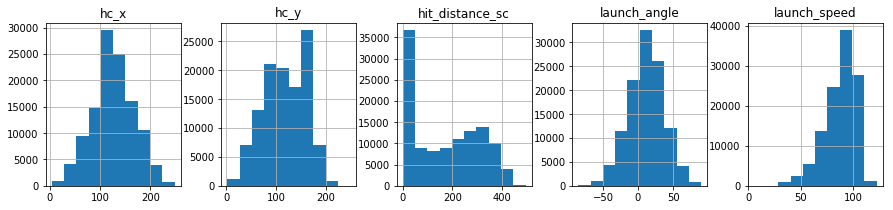

In [17]:
# another look at the data
dfBat.hist(figsize = (15,3), layout=(1,5))

## Step 3.  Augment the dataset with some columns needed for analysis

### 3a. Add a few basic columns

In [18]:
#add hit field (1 = hit, 0 = out)
dfBat['hit'] = dfBat['events'].isin(['single','double','triple', 'home_run']).astype(int)

#add righty field (1 - Batted right  0 - Batted left) - converts the 'stand' field to a binary value
dfBat['righty'] = dfBat['stand'].isin(['R']).astype(int)

#add hit angle - thanks to Bill Petti https://github.com/BillPetti/Statcast-Modeling
dfBat['horiz_angle'] = np.tan((dfBat['hc_x']-128) / (208-dfBat['hc_y'])) * 180 / np.pi * .75

#now caught ball - maybe fielder_choice out contains some caught balls, but the number of these is <.2%
#this field is use to train the model 
dfBat['caught'] = 0
dfBat.loc[dfBat['events'].isin(['field_out','sac_fly', 'sac_fly_double_play']), 'caught'] = 1


### 3b. Add column for color coding events

In [19]:
#add color coding for MLB 'events'
#todo:  simplify the descriptions later
#check out colormaps here https://matplotlib.org/examples/color/colormaps_reference.html
def func(row):
    if   row['events'] == 'single':                    return 1
    elif row['events'] == 'double':                    return 2
    elif row['events'] == 'triple':                    return 3
    elif row['events'] == 'home_run':                  return 4
    elif row['events'] == 'force_out':                 return 5 
    elif row['events'] == 'field_out':                 return 6 
    elif row['events'] == 'double_play':               return 7 
    elif row['events'] == 'field_error':               return 8 
    elif row['events'] == 'sac_fly':                   return 9 
    elif row['events'] == 'grounded_into_double_play': return 10 
    elif row['events'] == 'fielders_choice_out':       return 11 
    elif row['events'] == 'sac_bunt':                  return 12 
    elif row['events'] == 'fielders_choice':           return 13 
    elif row['events'] == 'sac_fly_double_play':       return 14 
    elif row['events'] == 'triple_play':               return 15 
    else: return '16'
dfBat['ecolor'] = dfBat.apply(func, axis=1)

### 3c. Add catch probability column and function for use with graphs

In [20]:
#add catch probability (this is take from work further down in the notebook)
#it was modeled somehow in this fangraphs report below
#https://www.fangraphs.com/community/lets-build-our-own-catch-probability-metric/

#1/(1+exp(-(-10.152 + 0.057 * launch_speed + 0.218 * launch_angle)))
#model 1
dfBat['catch_prob'] = 1/(1+np.exp(-(-10.152 + 0.057 * dfBat['launch_speed'] + 0.218 * dfBat['launch_angle'])))
#model 2
#dfBat['catch_probability'] = 1/(1+np.exp(-(3.72 + -.04 * dfBat['launch_speed'] + .015 * dfBat['launch_angle'])))

def catch_probability(speed, angle):
    g = 32.          #32 ft/sec/sec
    rad = np.pi/180 #degrees to radians
    xmph = 1.46667  #1 mph = 1.466667 fps

    v0 = speed * xmph
    h0 = 3.   #this is guess of where bat-ball contact zone is at time of a hit (in feet of the ground)
    cos0 = np.cos(angle*rad)
    sin0 = np.sin(angle*rad)
    
    dis = ((v0*cos0 * abs(v0*sin0 + np.sqrt(((v0*sin0)**2) + 2*h0*g)))/g)
    res = 1/(1+np.exp(-(-10.152 +  .057*speed + .218*angle)))
    if dis > 417:  #75% HR distance
        res = 0
    return res,dis

#now make homers a catch probability of zero
dfBat['catch_prob'][dfBat.events=='home_run'] = 0

### 3d.Take a final look at the data

In [21]:
dfBat.describe()
#note that there is missing statcast data on hit distance - we need to clean that up

,hc_x,hc_y,hit_distance_sc,launch_speed,launch_angle,hit,righty,horiz_angle,caught,ecolor,catch_prob
count,114810.000000,114810.000000,114810.000000,114810.000000,114810.000000,114810.000000,114810.000000,114810.000000,114810.000000,114810.000000,114810.000000
mean,125.989142,117.894782,171.223439,87.522548,11.743616,0.352051,0.589792,-4.542644,0.571457,4.654211,0.301666
std,41.433899,42.673230,137.017184,15.037037,25.477617,0.477612,0.491873,495.611741,0.494870,2.435282,0.386701
min,4.140000,2.260000,0.000000,5.200000,-84.987000,0.000000,0.000000,-115861.794768,0.000000,1.000000,0.000000
25%,101.280000,86.102500,23.000000,78.900000,-4.019000,0.000000,0.000000,-18.431627,0.000000,2.000000,0.000843
50%,125.355000,116.635000,170.000000,90.600000,12.396000,0.000000,1.000000,-1.834157,1.000000,6.000000,0.052866
75%,152.700000,153.950000,295.000000,98.800000,28.545500,1.000000,1.000000,15.419972,1.000000,6.000000,0.641553
max,248.000000,248.000000,495.000000,122.200000,89.850000,1.000000,1.000000,12179.918781,1.000000,15.000000,0.999999


In [22]:
#remove NaN rows 
#dfBat = dfBat.dropna(axis=0, how='any')

#reindex
dfBat.reset_index(inplace=True, drop=True)

dfBat.describe()

,hc_x,hc_y,hit_distance_sc,launch_speed,launch_angle,hit,righty,horiz_angle,caught,ecolor,catch_prob
count,114810.000000,114810.000000,114810.000000,114810.000000,114810.000000,114810.000000,114810.000000,114810.000000,114810.000000,114810.000000,114810.000000
mean,125.989142,117.894782,171.223439,87.522548,11.743616,0.352051,0.589792,-4.542644,0.571457,4.654211,0.301666
std,41.433899,42.673230,137.017184,15.037037,25.477617,0.477612,0.491873,495.611741,0.494870,2.435282,0.386701
min,4.140000,2.260000,0.000000,5.200000,-84.987000,0.000000,0.000000,-115861.794768,0.000000,1.000000,0.000000
25%,101.280000,86.102500,23.000000,78.900000,-4.019000,0.000000,0.000000,-18.431627,0.000000,2.000000,0.000843
50%,125.355000,116.635000,170.000000,90.600000,12.396000,0.000000,1.000000,-1.834157,1.000000,6.000000,0.052866
75%,152.700000,153.950000,295.000000,98.800000,28.545500,1.000000,1.000000,15.419972,1.000000,6.000000,0.641553
max,248.000000,248.000000,495.000000,122.200000,89.850000,1.000000,1.000000,12179.918781,1.000000,15.000000,0.999999


In [23]:
dfBat.head()

,events,stand,hc_x,hc_y,hit_distance_sc,launch_speed,launch_angle,home_team,hit,righty,horiz_angle,caught,ecolor,catch_prob
0,field_out,L,159.62,145.50,20.0,93.7,-5.348,LAD,0,0,23.807012,1,6,0.002530
1,field_out,R,135.89,169.21,23.0,55.5,-1.466,LAD,0,1,8.863167,1,6,0.000670
2,field_out,R,135.09,69.93,319.0,97.5,16.599,LAD,0,1,2.208578,1,6,0.273702
3,field_out,R,170.68,58.59,348.0,97.0,21.411,LAD,0,1,12.620357,1,6,0.511148
4,field_out,R,200.25,103.08,292.0,86.3,34.582,LAD,0,1,35.366617,1,6,0.909371


## Step 4.  Analyze the Augmented Dataset 

### 4a. Comparison with 538 New Science of Hitting Article
For a quick review - lets compare this dataset with the 538 New Science of Hitting Article
https://fivethirtyeight.com/features/the-new-science-of-hitting/

In [24]:
#Plotting variables
markersize=1  #dots on graph
markersize1=5
fs1 = 14  #fontsize
#colormaps = https://matplotlib.org/users/colormaps.html
cmap_bin = 'summer' #colormap binary
cmap_grad = 'autumn'
info = '(Yellow-hit, Green-out)'

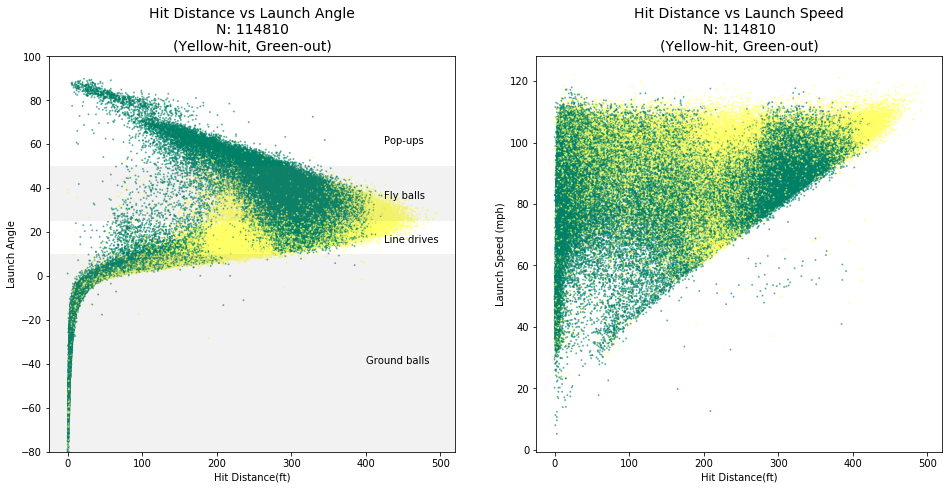

In [25]:
#Hit Distance vs Launch Angle
fig = plt.figure(1, figsize=(16,16))
plt.subplot(221)
plt.title('Hit Distance vs Launch Angle\nN: ' + str(len(dfBat)) + '\n' + info, fontsize=fs1)
plt.xlabel('Hit Distance(ft)')
plt.ylabel('Launch Angle')
plt.ylim(-80, 100)
plt.text(400,-40, 'Ground balls')
plt.text(425,15, 'Line drives')
plt.text(425,35, 'Fly balls')
plt.text(425,60, 'Pop-ups')
plt.axhspan(-80,10, facecolor='.5', alpha=.1)
plt.axhspan(25,50, facecolor='.5', alpha=.1)
plt.scatter(dfBat.hit_distance_sc, dfBat.launch_angle, c=dfBat.hit, cmap=cmap_bin, s = markersize, alpha=.5)

#Hit Distance vs Launch Speed
plt.subplot(222)
plt.title('Hit Distance vs Launch Speed\nN: ' + str(len(dfBat)) + '\n' + info, fontsize=fs1)
plt.xlabel('Hit Distance(ft)')
plt.ylabel('Launch Speed (mph)')
plt.scatter(dfBat.hit_distance_sc, dfBat.launch_speed, c=dfBat.hit, cmap=cmap_bin, s=markersize, alpha=.5)

plt.show()


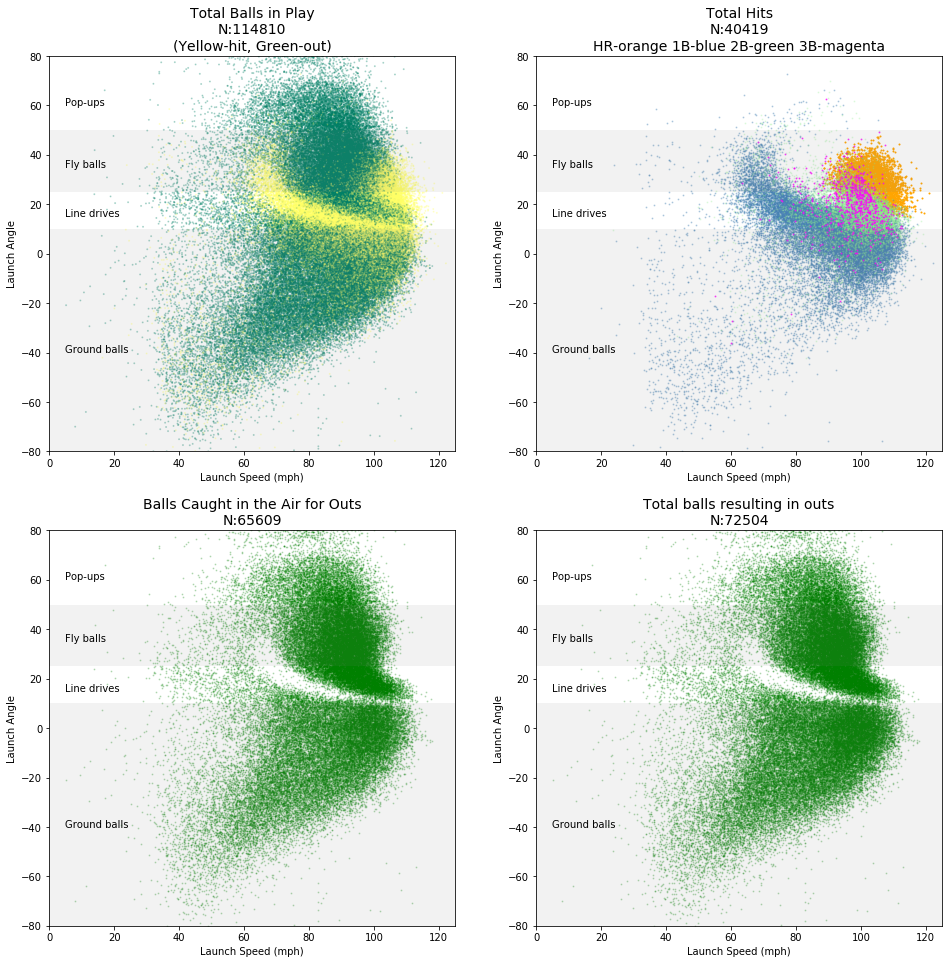

In [26]:
#Launch Speed vs Launch Angle
fig = plt.figure(2, figsize=(16,16))
plt.subplot(221)
plt.title('Total Balls in Play\nN:' + str(len(dfBat)) + '\n' + info, fontsize=fs1)
plt.xlabel('Launch Speed (mph)')
plt.ylabel('Launch Angle')
plt.xlim(0, 125)
plt.ylim(-80, 80)
plt.text(5,-40, 'Ground balls')
plt.text(5,15, 'Line drives')
plt.text(5,35, 'Fly balls')
plt.text(5,60, 'Pop-ups')
plt.axhspan(-80,10, facecolor='.5', alpha=.1)
plt.axhspan(25,50, facecolor='.5', alpha=.1)
plt.scatter(dfBat.launch_speed, dfBat.launch_angle, c=dfBat.hit, cmap=cmap_bin, s=markersize, alpha=.25)

# now just by hit-type - build the datasets
dfBat['HR'] = 0
dfBat['1B'] = 0
dfBat['2B'] = 0
dfBat['3B'] = 0
dfBat.loc[dfBat['events'] == 'home_run', 'HR'] = 1
dfBat.loc[dfBat['events'] == 'single', '1B'] = 1
dfBat.loc[dfBat['events'] == 'double', '2B'] = 1
dfBat.loc[dfBat['events'] == 'triple', '3B'] = 1
dfHR = dfBat.loc[dfBat['HR'] ==1]
df1B = dfBat.loc[dfBat['1B'] ==1]
df2B = dfBat.loc[dfBat['2B'] ==1]
df3B = dfBat.loc[dfBat['3B'] ==1]
lenhits = len(dfHR) + len(df1B) + len(df2B) + len(df3B)

#Launch Speed vs Launch Angle by Hit Type
plt.subplot(222)
plt.title('Total Hits\nN:' + str(lenhits) + '\nHR-orange 1B-blue 2B-green 3B-magenta', fontsize=fs1)
plt.xlabel('Launch Speed (mph)')
plt.ylabel('Launch Angle')
plt.xlim(0, 125)
plt.ylim(-80, 80)
plt.text(5,-40, 'Ground balls')
plt.text(5,15, 'Line drives')
plt.text(5,35, 'Fly balls')
plt.text(5,60, 'Pop-ups')
plt.axhspan(-80,10, facecolor='.5', alpha=.1)
plt.axhspan(25,50, facecolor='.5', alpha=.1)
plt.scatter(dfHR.launch_speed, dfHR.launch_angle, c='orange', s=markersize)
plt.scatter(df1B.launch_speed, df1B.launch_angle, c='steelblue', s=markersize, alpha=.3)
plt.scatter(df2B.launch_speed, df2B.launch_angle, c='lightgreen', s=markersize, alpha=.2)
plt.scatter(df3B.launch_speed, df3B.launch_angle, c='magenta', s=markersize, alpha=.6)

#Launch Speed and Angle for Caught Balls
dfCaught = dfBat.loc[dfBat['caught'] ==1]
plt.subplot(223)
plt.title('Balls Caught in the Air for Outs\nN:' + str(len(dfCaught)),  fontsize=fs1)
plt.xlabel('Launch Speed (mph)')
plt.ylabel('Launch Angle')
plt.xlim(0, 125)
plt.ylim(-80, 80)
plt.text(5,-40, 'Ground balls')
plt.text(5,15, 'Line drives')
plt.text(5,35, 'Fly balls')
plt.text(5,60, 'Pop-ups')
plt.axhspan(-80,10, facecolor='.5', alpha=.1)
plt.axhspan(25,50, facecolor='.5', alpha=.1)
plt.scatter(dfCaught.launch_speed, dfCaught.launch_angle, c='green', s=markersize, alpha=.2)

          
#Now just for all outs
dfBat['out'] = dfBat['caught']
dfBat.loc[dfBat['events'].isin(['force_out', 'grounded_into_double_play', 'fielders_choice_out', 
                                'fielders_choice', 'triple_play']), 'out'] = 1
dfOut = dfBat.loc[dfBat['out'] ==1]
#Launch Speed vs Launch Angle
plt.subplot(224)
plt.title('Total balls resulting in outs\nN:' + str(len(dfOut)),  fontsize=fs1)
plt.xlabel('Launch Speed (mph)')
plt.ylabel('Launch Angle')
plt.xlim(0, 125)
plt.ylim(-80, 80)
plt.text(5,-40, 'Ground balls')
plt.text(5,15, 'Line drives')
plt.text(5,35, 'Fly balls')
plt.text(5,60, 'Pop-ups')
plt.axhspan(-80,10, facecolor='.5', alpha=.1)
plt.axhspan(25,50, facecolor='.5', alpha=.1)
plt.scatter(dfOut.launch_speed, dfOut.launch_angle, c='green', s=markersize, alpha=.2)

plt.show()
          

### 4b. Ball in play location on the field
#### Notice minor 'masked' areas from the Statcast data - must be a bug in Statcast

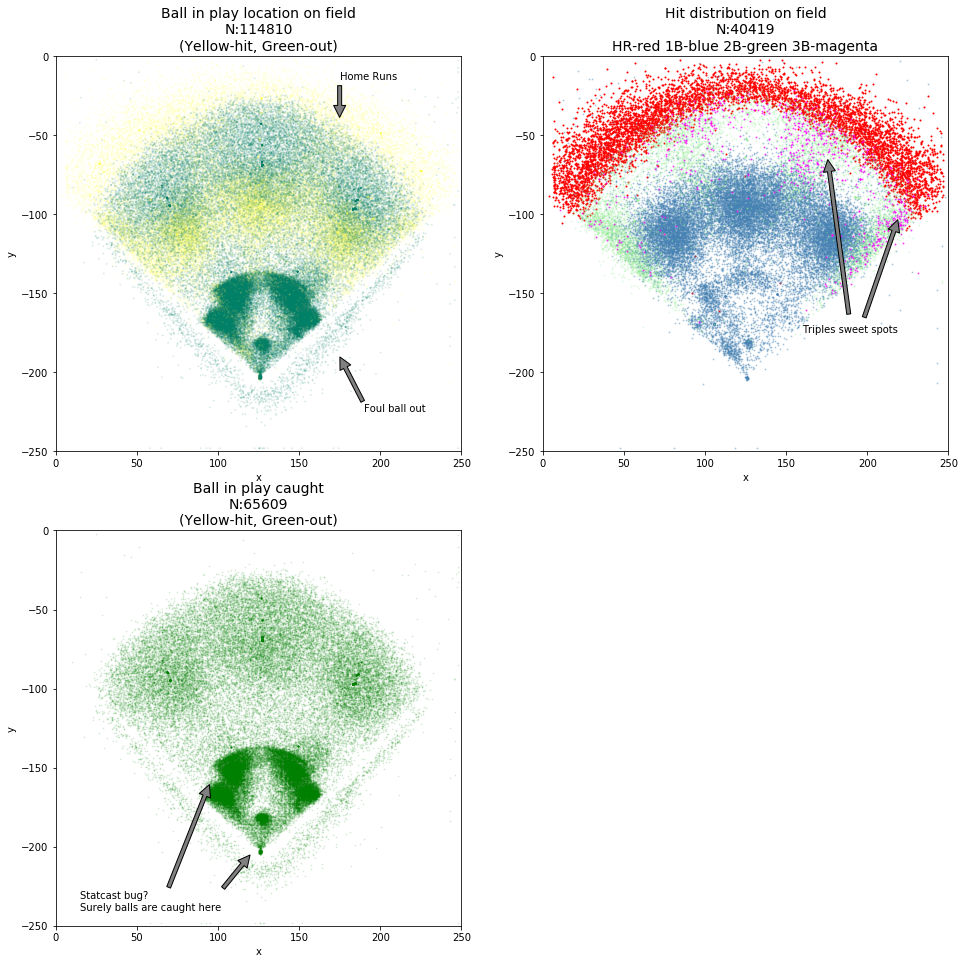

In [27]:
#Ball in  play Location on ballfield
fig = plt.figure(3, figsize=(16,16))
plt.subplot(221)
plt.title('Ball in play location on field\nN:' + str(len(dfBat)) + '\n' + info, fontsize=fs1)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0,250)
plt.ylim(-250,0)
plt.annotate('Foul ball out', xy=(175,-190), xytext=(190,-225),
            arrowprops=dict(facecolor='grey', shrink=0.01),)
plt.annotate('Home Runs', xy=(175,-40), xytext=(175,-15),
            arrowprops=dict(facecolor='grey', shrink=0.05),)
plt.scatter(dfBat.hc_x, -dfBat.hc_y, c=dfBat.hit, cmap=cmap_bin, s=markersize, alpha=.1)

#distribution of hit type on ballfield
plt.subplot(222)
plt.title('Hit distribution on field\nN:' + str(lenhits)+ '\nHR-red 1B-blue 2B-green 3B-magenta', fontsize=fs1)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0,250)
plt.ylim(-250,0)
plt.scatter(dfHR.hc_x, -dfHR.hc_y, c='red', cmap=cmap_grad, s=markersize, alpha=1)
plt.scatter(df1B.hc_x, -df1B.hc_y, c='steelblue', s=markersize, alpha=.3)
plt.scatter(df2B.hc_x, -df2B.hc_y, c='lightgreen', s=markersize, alpha=.2)
plt.scatter(df3B.hc_x, -df3B.hc_y, c='magenta', s=markersize, alpha=.6)
plt.annotate('Triples sweet spots', xy=(175,-60), xytext=(160,-175),
            arrowprops=dict(facecolor='grey', shrink=0.05),)
plt.annotate('                   ', xy=(220,-100), xytext=(160,-175),
            arrowprops=dict(facecolor='grey', shrink=0.05),)

#Ball Caught on field
plt.subplot(223)
plt.title('Ball in play caught\nN:' + str(len(dfCaught)) + '\n' + info, fontsize=fs1)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0,250)
plt.ylim(-250,0)
plt.scatter(dfCaught.hc_x, -dfCaught.hc_y, c='green', cmap=cmap_bin, s=markersize, alpha=.1)
plt.annotate('Statcast bug?\nSurely balls are caught here', xy=(120,-205), xytext=(15,-240),
            arrowprops=dict(facecolor='grey', shrink=0.01),)
plt.annotate('             \n                            ', xy=(95,-160), xytext=(15,-240),
            arrowprops=dict(facecolor='grey', shrink=0.01),)

plt.show()

### 4c. Want to check out "ball in play location" for your favorite ballpark?

In [28]:
def ballpark_hits(Stadium):
   #distribution of hit type for one ballfield
   #city = 'SF'
   city = Stadium
   dfHR['stadium'] = 0
   df1B['stadium'] = 0
   df2B['stadium'] = 0
   df3B['stadium'] = 0
   dfHR.loc[dfHR['home_team'] == city, 'stadium'] = 1
   df1B.loc[df1B['home_team'] == city, 'stadium'] = 1
   df2B.loc[df2B['home_team'] == city, 'stadium'] = 1
   df3B.loc[df3B['home_team'] == city, 'stadium'] = 1

   dfStadiumHR = dfHR.loc[dfHR['stadium'] == 1]
   dfStadium1B = df1B.loc[df1B['stadium'] == 1]
   dfStadium2B = df2B.loc[df2B['stadium'] == 1]
   dfStadium3B = df3B.loc[df3B['stadium'] == 1]

   x1=np.linspace(128,225,10)
   x2=np.linspace(25,128,10)
   y1= (-330+x1)
   y2= (-75+x2*-1)

   fig = plt.figure(figsize=(6,6))
   plt.title('Hit distribution for ' + city + ' Ballpark\nHR-red 1B-blue 2B-green 3B-magenta\nn: ' + 
             str(len(dfStadiumHR)+len(dfStadium1B)+len(dfStadium2B)+len(dfStadium3B)))
   plt.xlabel('x')
   plt.ylabel('y')
   plt.xlim(0,250)
   plt.ylim(-250,0)
   plt.plot(x1,y1, c='black', alpha=.5, linewidth=4)
   plt.plot(x2,y2, c='black', alpha=.5, linewidth=4)
   plt.scatter(dfStadiumHR.hc_x, -dfStadiumHR.hc_y, c='red', cmap=cmap_grad, s=markersize*3, alpha=1)
   plt.scatter(dfStadium1B.hc_x, -dfStadium1B.hc_y, c='blue', s=markersize*3, alpha=1)
   plt.scatter(dfStadium2B.hc_x, -dfStadium2B.hc_y, c='green', s=markersize*3, alpha=1)
   plt.scatter(dfStadium3B.hc_x, -dfStadium3B.hc_y, c='magenta', s=markersize*3, alpha=1)
   
   plt.show()

In [29]:
#Have fun with your favorite stadium
items = sorted(dfBat['home_team'].unique().tolist())

i1 = interact_manual(ballpark_hits, Stadium=items)

A Jupyter Widget

## Step 5. Prove Statcast metrics of launch angle and speed are statistically valid

What do we compare these metrics with to see if they are valid?   How about statcast reported distance?
Lets go back to high-school physics to see if we can prove that they are valid.
### 5a. High School projectile physics


![](https://i.imgur.com/tYQ9cT3.png)

### 5b. Physics model for distance (no air resistance)
##### High School Physics revisited - http://www.splung.com/content/sid/2/page/projectiles

How far does a ball travel (s) from home plate when:
1. bat speed (v0) = launch_speed from Statcast
2. theta = launch angle from Statcast
3. h0 = height of where ball hits bat (lets assume 2.5 feet off ground)

\begin{align}
s = \frac{v_0cos\theta\mid v_0sin\theta + \sqrt{(v_0sin\theta)^2+ 2h_0g} \mid}{g}
\end{align}


In [30]:
#high school physics - how far does a canonball go when shot from a mountaintop at a certain angle...

g = 32.          #32 ft/sec/sec
rad = np.pi/180 #degrees to radians
xmph = 1.46667  #1 mph = 1.466667 fps

v0 = dfBat['launch_speed'] * xmph
h0 = 3.   #this is guess of where bat-ball contact zone is at time of a hit (in feet of the ground)
cos0 = np.cos(dfBat['launch_angle']*rad)
sin0 = np.sin(dfBat['launch_angle']*rad)
theta = dfBat['launch_angle']*rad

dfBat['dist_calc1'] = ((v0*cos0 * abs(v0*sin0 + np.sqrt(((v0*sin0)**2) + 2*h0*g)))/g)

#does physics model look reasonable?
    
dftmp = dfBat.loc[dfBat['HR'] != 1].copy()  #remove HR from regression
dftmp = dftmp[['hit_distance_sc', 'launch_speed', 'launch_angle', 'dist_calc1']]
dftmp['delta'] = dftmp.dist_calc1 - dftmp.hit_distance_sc


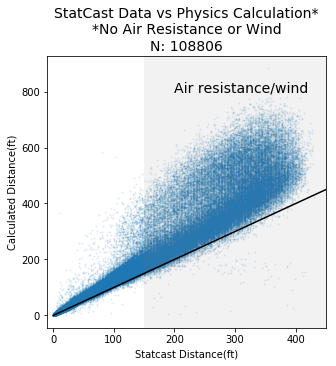

In [58]:
#show relationship between calculated and StatCast produced distance
fig = plt.figure(figsize=(5,5))
plt.scatter(dftmp.hit_distance_sc, dftmp.dist_calc1, s=markersize, alpha=.1)
plt.title('StatCast Data vs Physics Calculation*\n*No Air Resistance or Wind\nN: ' + str(len(dftmp)), fontsize=fs1)
plt.xlabel('Statcast Distance(ft)')
plt.ylabel('Calculated Distance(ft)')

x = arange(0,450, 1)
plt.xlim(-10,450)
plt.text(200,800, 'Air resistance/wind',fontsize=14)
plt.axvspan(150,500, facecolor='.5', alpha=.1)
plt.plot(x,x, c='black')
plt.show()

### 5c. Physics model for distance (adjust for air resistance/wind)
From the Graph and DataSet we can see that StatCasts is less than Physics calc, and results have a much wider variance after 200.
Air resistance is likely the largest factor here.  Lets see if we can adjust with OLS model.

#### Factors
Future things to look into:
 - air resistance (there is an exponential decay of horizontal velocity
 - wind speed and direction
 - Statcast excluding baselines and first and third base in ball hit locations

In [32]:
#model - prediction
m = sm.OLS.from_formula('hit_distance_sc ~ dist_calc1', dftmp)

#calculate the residuals
res = m.fit()
print (res.summary())

                            OLS Regression Results                            
Dep. Variable:        hit_distance_sc   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                 9.416e+05
Date:                Sun, 29 Apr 2018   Prob (F-statistic):               0.00
Time:                        00:19:47   Log-Likelihood:            -5.6009e+05
No. Observations:              108806   AIC:                         1.120e+06
Df Residuals:                  108804   BIC:                         1.120e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.2587      0.193     89.551      0.0

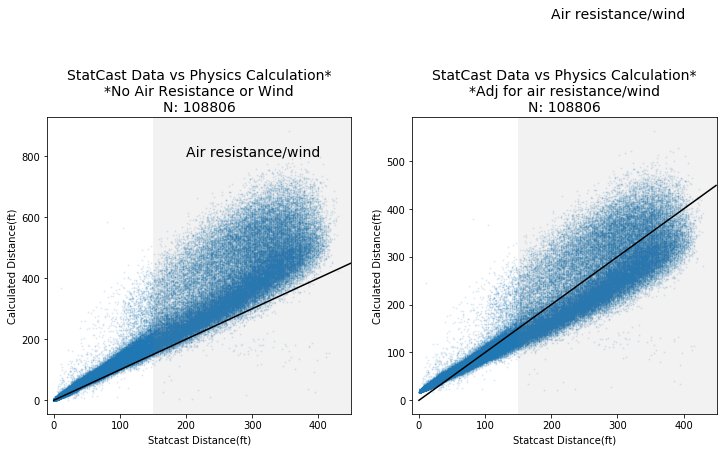

In [33]:
#compare the two models
dftmp['dist_calc_ols'] = 17.2587 + .6186 * dftmp['dist_calc1']

x = arange(0,450, 1)

#show relationship between calculated and stat-cast produced distance
fig = plt.figure(9, figsize=(12,12))
plt.subplot(221)
plt.scatter(dftmp.hit_distance_sc, dftmp.dist_calc1, s=markersize, alpha=.1)
plt.title('StatCast Data vs Physics Calculation*\n*No Air Resistance or Wind\nN: ' + str(len(dftmp)), fontsize=fs1)
plt.xlabel('Statcast Distance(ft)')
plt.ylabel('Calculated Distance(ft)')
plt.xlim(-10,450)
plt.text(200,800, 'Air resistance/wind',fontsize=14)
plt.axvspan(150,500, facecolor='.5', alpha=.1)
plt.plot(x,x, c='black')

plt.subplot(222)
#show relationship between calculated and stat-cast produced distance
plt.scatter(dftmp.hit_distance_sc, dftmp.dist_calc_ols, s=markersize, alpha=.1)
plt.title('StatCast Data vs Physics Calculation*\n*Adj for air resistance/wind\nN: ' + str(len(dftmp)), fontsize=fs1)
plt.xlabel('Statcast Distance(ft)')
plt.ylabel('Calculated Distance(ft)')
plt.xlim(-10,450)
plt.text(200,800, 'Air resistance/wind',fontsize=14)
plt.axvspan(150,500, facecolor='.5', alpha=.1)
plt.plot(x,x, c='black')
plt.show()

#### If we combine the physics math with a linear model, we get a 90% R-squared value

This physics model modified for wind resistance has 90% correlation with statcast data.

## Step 6. Develop a model that forward predicts 'catch probability'

### 6a. Is 'caught' correlated using OLS model?

spoiler alert - no...

In [34]:
features = dfBat.loc[dfBat['HR'] != 1].copy()  #remove HR from regressio
features = features[['caught','launch_speed', 'launch_angle', 'horiz_angle', 'righty', 'hit_distance_sc']]

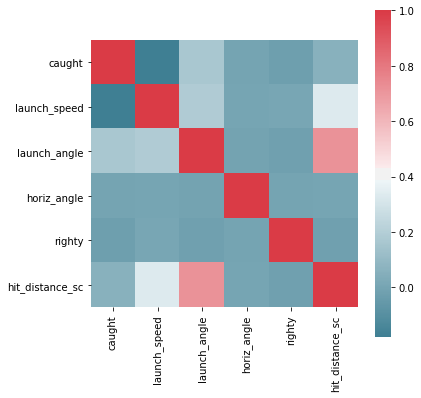

In [35]:
#correlation Heatmap
import seaborn as sns

f, ax = plt.subplots(figsize=(6, 6))
corr = features.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [36]:
#model - prediction
#m = sm.OLS.from_formula('hit ~ launch_speed + launch_angle + hit_distance_sc', dfBat)
m = sm.OLS.from_formula('caught ~ launch_speed + launch_angle', features)

In [37]:
#calculate the residuals
res = m.fit()
print (res.summary())

                            OLS Regression Results                            
Dep. Variable:                 caught   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     4276.
Date:                Sun, 29 Apr 2018   Prob (F-statistic):               0.00
Time:                        00:19:56   Log-Likelihood:                -72496.
No. Observations:              108806   AIC:                         1.450e+05
Df Residuals:                  108803   BIC:                         1.450e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.1756      0.008    138.934   

Looks like linear OLS model is not very good for predicting whether we got caught a ball (R-squared < .1)

### 6b. Is 'caught' correlated using a Machine Learning Logistics model?

We learned about this in discrete math, and it seems to be part of every elementary machine learning class.

##### Good news 

In [38]:
features = dfBat.loc[dfBat['HR'] != 1].copy()  #remove HR from regression
features = features[['caught','launch_speed', 'launch_angle']]

### 6c. Summarize and checkout the 'features' data

In [39]:
#print X.columns
features.head()

,caught,launch_speed,launch_angle
0,1,93.7,-5.348
1,1,55.5,-1.466
2,1,97.5,16.599
3,1,97.0,21.411
4,1,86.3,34.582


In [40]:
features.describe()

,caught,launch_speed,launch_angle
count,108806.000000,108806.000000,108806.000000
mean,0.602991,86.661505,10.842579
std,0.489280,14.943444,25.843416
min,0.000000,5.200000,-84.987000
25%,0.000000,78.100000,-5.192000
50%,1.000000,89.600000,10.805000
75%,1.000000,97.700000,27.576000
max,1.000000,122.200000,89.850000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96bd0e0a90>,
      dtype=object)

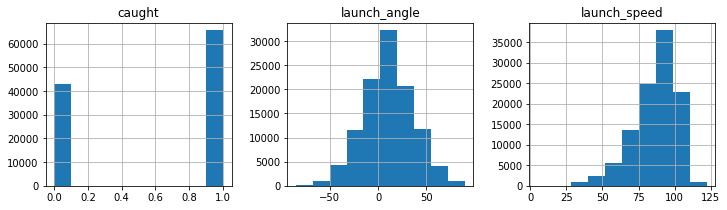

In [41]:
#confirm what are features look like
features.hist(figsize = (12,3), layout=(1,3))

In [42]:
# add and intercept
features['intercept'] = 1.0

### 6d. run and train the logistics model

In [43]:
#now the  Logistic Regression
train_cols = features.columns[1:]
X = features[train_cols]
y = features['caught']
logit = sm.Logit(y, X)

#fit the model
res = logit.fit()

Optimization terminated successfully.
         Current function value: 0.632884
         Iterations 5


### 6e. interpret the logistics model

In [44]:
#interpret the results
print res.summary()

print "\n\nConfidence Intervals\n", res.conf_int()

#p-values are all smaller than .05 so features are significant to the model

                           Logit Regression Results                           
Dep. Variable:                 caught   No. Observations:               108806
Model:                          Logit   Df Residuals:                   108803
Method:                           MLE   Df Model:                            2
Date:                Sun, 29 Apr 2018   Pseudo R-squ.:                 0.05790
Time:                        00:20:02   Log-Likelihood:                -68862.
converged:                       True   LL-Null:                       -73094.
                                        LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
launch_speed    -0.0333      0.000    -70.394      0.000      -0.034      -0.032
launch_angle     0.0185      0.000     67.303      0.000       0.018       0.019
intercept        3.1471      0.042     75.77

In [45]:
#odds ratio
print (res.params)


launch_speed   -0.033275
launch_angle    0.018470
intercept       3.147063
dtype: float64


In [46]:
#odds ratios with confidence intervals
params = res.params
conf = res.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf)

                   2.5%      97.5%         OR
launch_speed   0.966377   0.968169   0.967273
launch_angle   1.018093   1.019189   1.018641
intercept     21.448613  25.240920  23.267633


### 6f. Adjust the model for homeruns

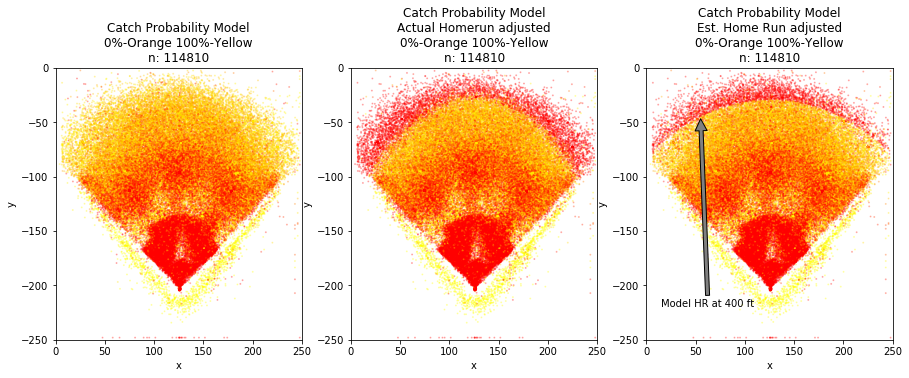

In [47]:
#Prob of out - Location on ballfield
#dfBat1 - no homerun adjustment  
#dfBat - homerun adjusted

dfBat1 = dfBat.copy()
dfBat1['catch_prob'] = 1/(1+np.exp(-(-10.152 + 0.057 * dfBat1['launch_speed'] + 0.218 * dfBat1['launch_angle'])))
dfBat2=dfBat1.copy()
#model average distance to back wall of park
dfBat2.loc[dfBat2['hit_distance_sc'] >= 400, 'catch_prob'] = 0

#Does that probability of catch predictor look reasonable?
fig = plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Catch Probability Model\n0%-Orange 100%-Yellow\nn: ' + str(len(dfBat)))
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0,250)
plt.ylim(-250,0)
plt.scatter(dfBat1.hc_x, -dfBat1.hc_y, c=dfBat1.catch_prob, cmap=cmap_grad, s=markersize, alpha=.25)

plt.subplot(132)
plt.title('Catch Probability Model\nActual Homerun adjusted\n0%-Orange 100%-Yellow\nn: ' + str(len(dfBat)))
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0,250)
plt.ylim(-250,0)
plt.scatter(dfBat.hc_x, -dfBat.hc_y, c=dfBat.catch_prob, cmap=cmap_grad, s=markersize, alpha=.25)

plt.subplot(133)
plt.title('Catch Probability Model\nEst. Home Run adjusted\n0%-Orange 100%-Yellow\nn: ' + str(len(dfBat)))
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0,250)
plt.ylim(-250,0)
plt.scatter(dfBat.hc_x, -dfBat.hc_y, c=dfBat2.catch_prob, cmap=cmap_grad, s=markersize, alpha=.25)
plt.annotate('Model HR at 400 ft', xy=(55,-45), xytext=(15,-220), arrowprops=dict(facecolor='grey', shrink=0.01))

plt.show()

In [48]:
# logistic regression model fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

### 6g. Deploy and Evaluate the model (slightly different library this time)

In [49]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
#calculate accuracy
y_pred = LogReg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(LogReg.score(X_test, y_test)))
print "Always predicting 'caught' gives you: {:.2f}".format(y.mean())

Accuracy of logistic regression classifier on test set: 0.63
Always predicting 'caught' gives you: 0.60


In [51]:
#Now lets look at the co-efficients
#pd.DataFrame(zip(X.columns, np.transpose(LogReg.coef_)))
print "Caught Probability = ", LogReg.coef_

Caught Probability =  [[-0.0331465   0.01822472  1.56707704]]


In [52]:
y_pred = LogReg.predict(X_test)

In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[ 4732,  8174],
       [ 3842, 15894]])

This tells us that 4732 and 15894 are correct predictions.   3842 and 8174 are incorrect

In [54]:
print(classification_report(y_test, y_pred))
print "Overall accuracy: " ,LogReg.score(X_test,y_test)

             precision    recall  f1-score   support

          0       0.55      0.37      0.44     12906
          1       0.66      0.81      0.73     19736

avg / total       0.62      0.63      0.61     32642

Overall accuracy:  0.6318853011457631


### 6h.    Model is 63% accurate - Not two bad from only TWO features

## Step 7 - Quick Interactive Application

### Interactive widget that pulls it all together

In [55]:
# This function plots dataset - for interactive widget
def ballpark(hit_speed, hit_angle, stadium):
    #select stadium data

    if stadium == 'ALL':
        dfFinal = dfBat
        scale=2
    else:
        dfBat['stadium'] = 0
        dfBat.loc[dfBat['home_team'] == stadium, 'stadium'] = 1
        dfFinal = dfBat.loc[dfBat['stadium'] == 1]
        scale=5
        
    #balls hit with a specific angle and velocity
    #could use outs added
    #could use a map
    v = hit_speed
    v_delta=4
    ang = hit_angle
    ang_delta=3

    #for drawing baselines
    x1=np.linspace(128,225,10)
    x2=np.linspace(25,128,10)
    y1= (-330+x1)
    y2= (-75+x2*-1)
    prob, dis = catch_probability(v, ang)  #lookup from the model
    dfFinal['sv'] = 0
    dfFinal.loc[dfFinal['launch_angle'].between(ang-ang_delta, ang+ang_delta) & 
             dfFinal['launch_speed'].between(v-v_delta, v+v_delta), 'sv'] = 1
    #dfBat.loc[dfBat['home_team'] == stadium, 'stadium'] = 1
    dfSV = dfFinal.loc[dfFinal['sv'] == 1]

    colors =  plt.cm.tab20( (4./3*np.arange(20*3/4)).astype(int) )
    fig = plt.figure(figsize=(14,14))
    #by event type
    plt.subplot(331)
    plt.title('Ball in Play by Hit Type\nLaunch angle: ' + str(ang) + '    Launch speed: ' + str(v)+
              '\nN: ' + str(len(dfSV)) +
                '   Prob of catch: ' + '{:3.1f}'.format(prob*100)+ '%', fontsize=14)
    plt.xlim(0,250)
    plt.ylim(-250,0)
    plt.plot(x1,y1, c='black', alpha=.5, linewidth=4)
    plt.plot(x2,y2, c='black', alpha=.5, linewidth=4)
    plt.scatter(dfSV.hc_x, -dfSV.hc_y, c=colors[dfSV.ecolor], cmap='tab20c',  s=(markersize1*scale), alpha=1)
    #plt.scatter(dfSV.hc_x, -dfSV.hc_y, c=dfSV.ecolor1.value(),   s=(markersize1*scale), alpha=1)
    
    #by caught
    plt.subplot(333)
    plt.title('Ball in Play by Caught/Not Caught\nNot caught-Red Caught-Yellow\nLaunch angle: ' + 
              str(ang) + '    Launch speed: ' + str(v) + '\nN: ' + str(len(dfSV)) +
              '   Prob of catch: ' + '{:3.1f}'.format(prob*100)+ '%', fontsize=14)
    plt.xlim(0,250)
    plt.ylim(-250,0)
    plt.plot(x1,y1, c='black', alpha=.5, linewidth=4)
    plt.plot(x2,y2, c='black', alpha=.5, linewidth=4)
    plt.scatter(dfSV.hc_x, -dfSV.hc_y, c=dfSV.caught, cmap='autumn',  s=(markersize1*scale), alpha=1)
    
    #by event type
    plt.subplot(332)
    img=mpimg.imread('colormap2.png')
    imgplot=plt.imshow(img)
    plt.axis('off')
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    plt.show()
    
city = ['ALL']+sorted(dfBat['home_team'].unique().tolist())    

In [56]:
i = interact_manual(ballpark,
            hit_speed = (30, 120, 5),
            hit_angle = (-44, 80, 2),
                   stadium=city)

A Jupyter Widget

4402345738240